In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sys

from pycox.evaluation import EvalSurv

from gen_syn_data import DGP_v3
from model.helpers import normalize_log_probs, KL_standard_normal
from model.cVAE import Encoder, SurvivalDecoder, ObservationDecoder, cVAE

**Generate synthetic example**

In [2]:
sample_generator = DGP_v3()
X = sample_generator.generate_samples(N=2000, random_state = 11)

**Train and Test set**

In [3]:
def prepare_train_set( dataset, p = [0.8, 0.1, 0.1], random_state = 13 ):
    N = dataset.shape[0]
    proportion = np.cumsum(p)

    torch.manual_seed(random_state)
    idx = torch.randperm(N)

    train_idx = idx[: int(N * proportion[0])]
    val_idx = idx[int(N * proportion[0]):int(N * proportion[1])]
    test_idx = idx[int(N * proportion[1]): ]

    train = dataset[train_idx, :]
    val = dataset[val_idx, :]
    test = dataset[test_idx, :]
    
        
    return train, val, test

In [4]:
X_train, X_val, X_test = prepare_train_set(X)

In [5]:
# dictionary that contains indices for each model component 
indexs = {}
indexs['t'] = [0]
indexs['s'] = [1]
indexs['x'] = [2,3,4]
indexs['c'] = [5,6]
indexs['a'] = [7]
indexs['b'] = [8]

**Visualise the dataset**

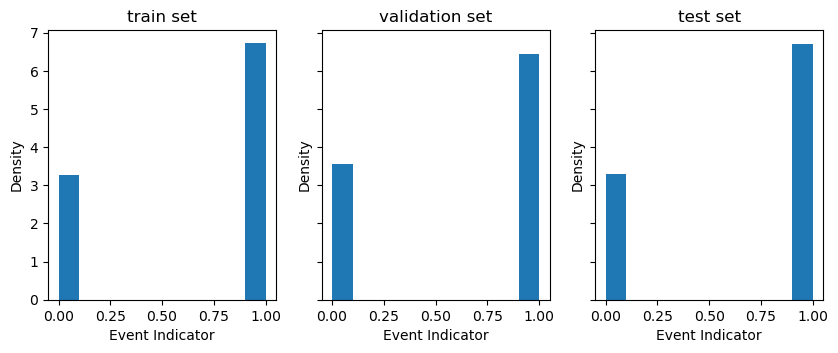

In [6]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3.5), sharey='all')

axs[0].hist(X_train[:, indexs['s']].flatten(), bins = 10, density = True)
axs[1].hist(X_val[:, indexs['s']].flatten(), bins = 10, density = True)
axs[2].hist(X_test[:, indexs['s']].flatten(), bins = 10, density = True)

axs[0].set_title("train set")
axs[1].set_title("validation set")
axs[2].set_title("test set")

for ax in axs.ravel():
    ax.set_xlabel("Event Indicator")
    ax.set_ylabel("Density")
plt.show()

**Train the model; note that the early stopping has been applied**

In [7]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [8]:
train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)

training = False
batch_size = 256
shuffle = training
data_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=shuffle)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
device= 'cpu'

In [9]:
# Specify encoder and decoder
z_dim = 2
c_dim = len(indexs['c'])
x_dim = len(indexs['x'])
hidden_dim = 64

alpha = 0.4
alpha_name = "{:02.0f}".format(alpha*10)

beta = 1

cov_idx = indexs['a'] + indexs['b'] 
cov_dim = len(cov_idx)
encoder_idx = indexs['x'] + indexs['c']
y_idx = torch.arange(2 + x_dim + c_dim)


In [10]:
encoder = Encoder(encoder_idx, hidden_dim, z_dim, device=device)

obs_decoder = ObservationDecoder(c_dim, x_dim, hidden_dim, z_dim, cov_dim,
                 nonlinearity=nn.ReLU,
                 device="cpu")

surv_decoder = SurvivalDecoder(x_dim, hidden_dim, z_dim, cov_dim,
                 nonlinearity=nn.ReLU,
                 device="cpu", n = 15)

model = cVAE(encoder, obs_decoder, surv_decoder, lr=0.001, alpha = alpha)


if training:
    train_loss, val_loss = model.optimize(data_loader, 
                                          y_idx = y_idx, cov_idx = cov_idx, encoder_idx= encoder_idx, 
                                          n_epochs = 500, logging_freq = 10, data_loader_val=data_loader_val,
                                         max_wait = 20)
    torch.save(model.state_dict(),f"cvae_alpha_{alpha_name}")
#     sys.exit(0)
else:
    state_dict = torch.load(f"cvae_alpha_{alpha_name}")
    model.load_state_dict(state_dict)
    model.eval()


Encoder: cpu specified, cpu used
Decoder: cpu specified, cpu used
Decoder: cpu specified, cpu used
	Data set size 1600, batch size 256.

	Epoch:  0. Total loss:    73223.89
best_epoch: 0
	Epoch:  0. Total val loss:     8702.92
	Epoch: 10. Total loss:    32392.29
best_epoch: 10
	Epoch: 10. Total val loss:     3761.35
	Epoch: 20. Total loss:    10133.53
best_epoch: 20
	Epoch: 20. Total val loss:     1264.64
	Epoch: 30. Total loss:     8806.98
best_epoch: 30
	Epoch: 30. Total val loss:     1102.34
	Epoch: 40. Total loss:     8333.75
best_epoch: 40
	Epoch: 40. Total val loss:     1061.72
	Epoch: 50. Total loss:     7971.80
best_epoch: 50
	Epoch: 50. Total val loss:      996.26
	Epoch: 60. Total loss:     7995.70
	Epoch: 60. Total val loss:     1004.02
	Epoch: 70. Total loss:     7977.68
best_epoch: 70
	Epoch: 70. Total val loss:      992.97
	Epoch: 80. Total loss:     7774.66
best_epoch: 80
	Epoch: 80. Total val loss:      976.73
	Epoch: 90. Total loss:     7799.92
	Epoch: 90. Total val lo

In [11]:
def plot_loss( losses, name ):
    N = len(losses.keys())
    
    fig, axs = plt.subplots(nrows = 1, ncols = N, figsize = (5 * N, 4))
    for i, item in enumerate(losses.keys()):
        component = item[:5]
        IT = len(losses[item]) - 1
        axs[i].scatter(np.arange(IT), losses[item][:IT])
        axs[i].set_title(item)
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel("Loss")
    
    plt.tight_layout()
    

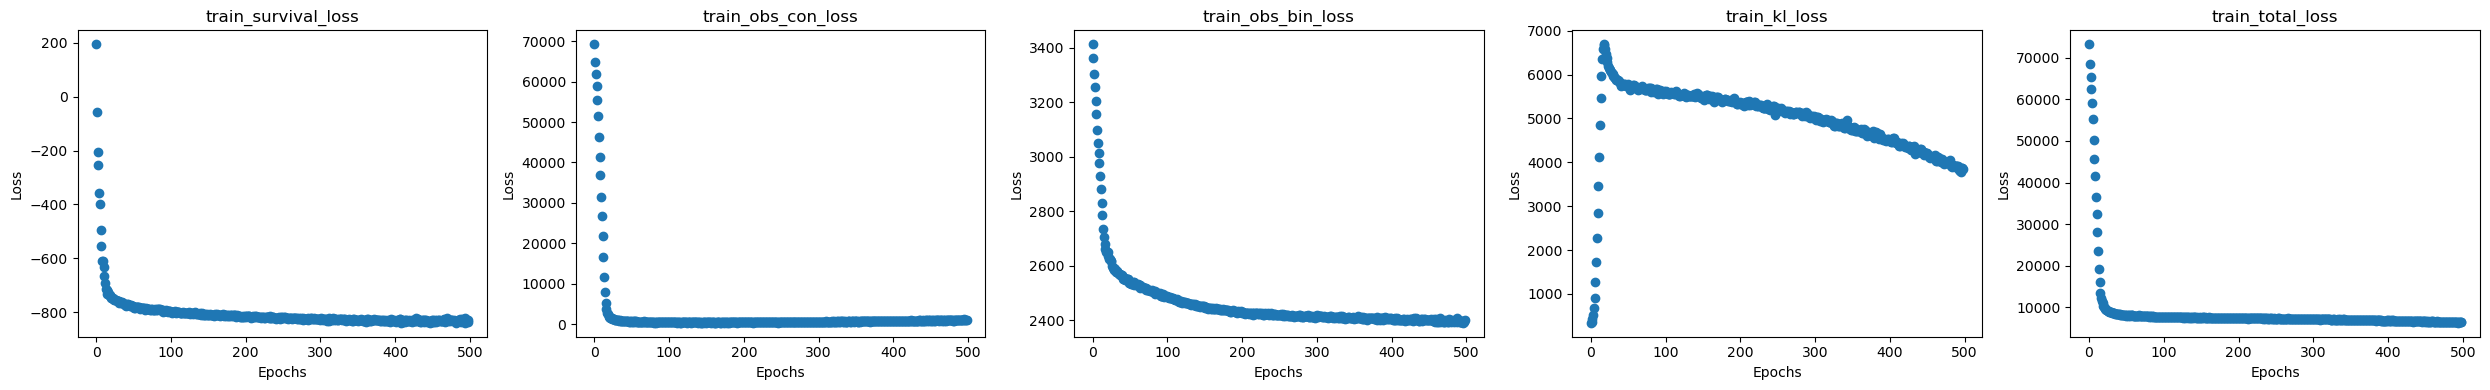

In [12]:
plot_loss(train_loss, name = 'train_set')

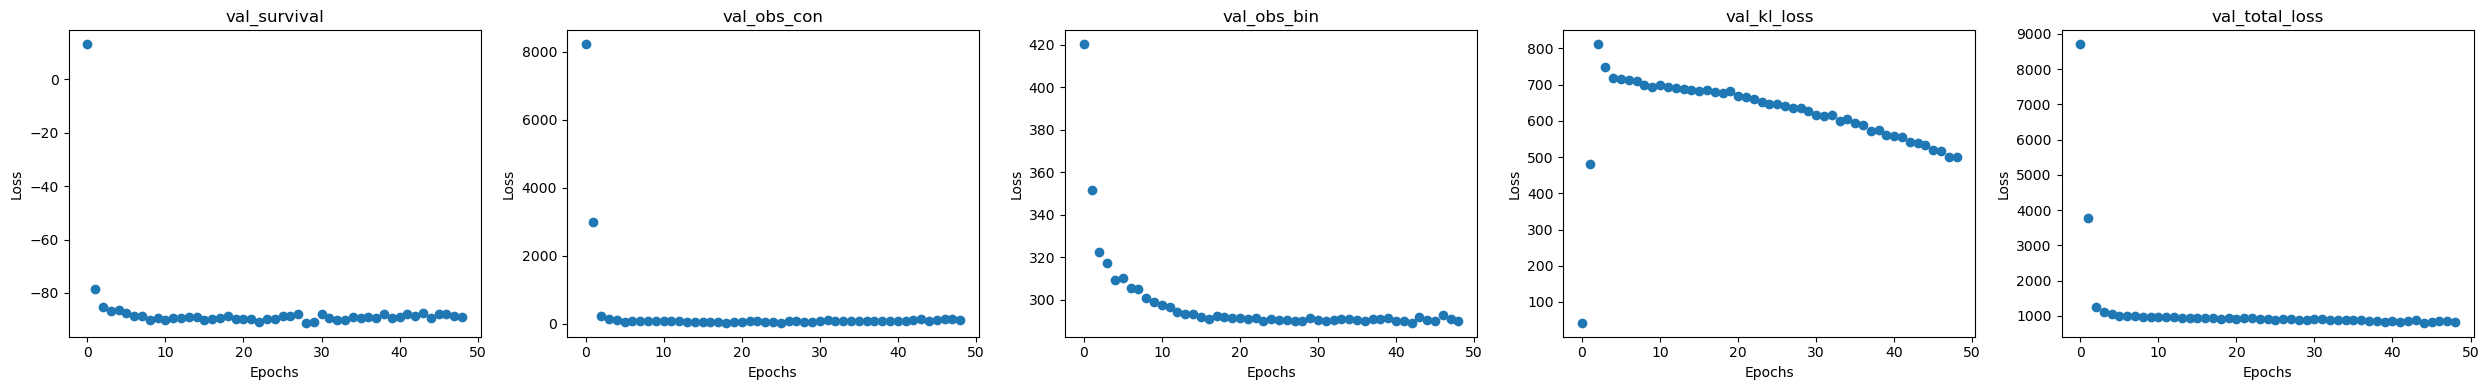

In [13]:
plot_loss(val_loss, name = 'validation_set')

**Reconstruction: observables**

In [14]:
import seaborn as sns

def reconstruct_x(feature):
            
    x_pred, c_pred = model.get_observables(feature[:, y_idx], feature[:, cov_idx], encoder_idx)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 8), sharey='all')
    axs[0].imshow(x_pred > 0.5, cmap='Greys', aspect = 0.01)
    axs[1].imshow(feature[:, indexs['x']], cmap='Greys', aspect = 0.01)
    # im = axs[2].imshow(X_val[:, indexs['x']] - x_pred, cmap='rainbow_r', aspect = 0.1)
    # cbar = plt.colorbar(im, ax=axs[2], aspect = 8)

    for ax in axs.ravel():
        ax.set_xlabel("Disease")
        ax.set_xticks(np.arange(len(indexs['x'])))
    axs[0].set_ylabel("Patients")
    axs[0].set_title("reconstruction")
    axs[1].set_title("data")
    
    plt.suptitle(f"binary observations reconstruction", y = 0.65)
    plt.tight_layout()
    plt.show()

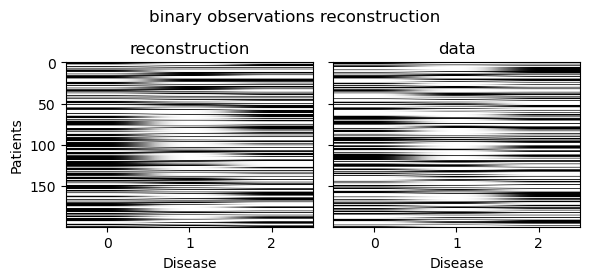

In [15]:
reconstruct_x(X_test)

In [16]:
def reconstruct_c(feature):
    x_pred, c_pred = model.get_observables(feature[:, y_idx], feature[:, cov_idx], encoder_idx)
    
    colors = sns.color_palette('hls', len(indexs['c']))
    fig, axs = plt.subplots(nrows=1, ncols = len(indexs['c']), figsize=(6, 4), sharey='all', sharex='all')
    
    for i in range(len(indexs['c'])):
        axs[i].scatter(c_pred[:, i], feature[:, indexs['c'][i]], label=f"$\mu_{i}$" + f" vs $c_{i}$", color=colors[i])
        axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, linestyle='--', color='gray', alpha=0.5)
        axs[i].set_xlabel(f"$\mu_{i}$")
        axs[i].set_ylabel(f"$c_{i}$")
        axs[i].legend()
    
    
    plt.suptitle(f"continuous observations reconstruction")
    plt.tight_layout()



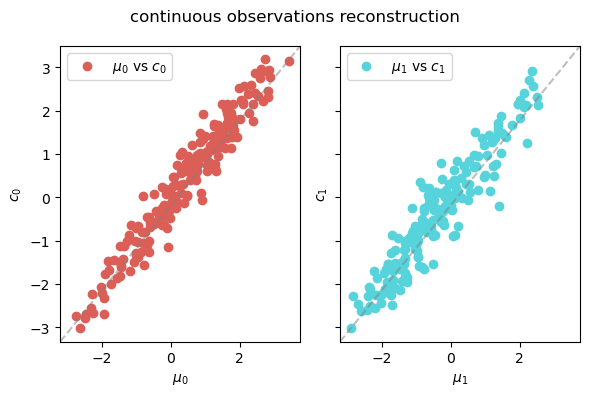

In [17]:
reconstruct_c(X_val)

**Evaluation: survival prediction**

In [18]:
def get_survival_curve(encoder, surv_decoder, encoder_idx, y, C, N = 500):
    assert y.shape[0] == 1, "survival curve is only for an individual"
    with torch.no_grad():
        mu_z, sigma_z = encoder(y[:, encoder_idx])

        t = torch.linspace(X_train[:, 0].min().item(), X_train[:, 0].max().item(), N)[:, None]
        
        x = torch.cat([t, mu_z.repeat(N, 1), C.repeat(N, 1)], 1)

        return t, surv_decoder.forward(x)


In [19]:
def pred_survival(i, dataset, N):
    t, curve = get_survival_curve(encoder, surv_decoder, encoder_idx, dataset[i, y_idx].reshape(1, -1), dataset[i, cov_idx].reshape(1, -1), N)
    plt.figure(figsize=(5, 3))
    plt.plot(t, 1 - curve, color='tab:red', label=f"Predictive Survival Curve, Death = {dataset[i, 1]}, Age = {np.round(dataset[i, indexs['a']].item(),3)}")
    plt.axvline(dataset[i, 0], color='grey', linestyle='dashed', label = "Time-to-event")
    plt.ylim([0, 1])
    plt.legend()
    plt.xlabel("Time-to-event")
    plt.ylabel("Probability")

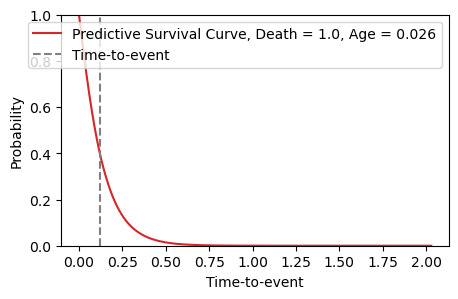

In [27]:
pred_survival(11, X_train, N = 1000)

**Prediction is made based on the posterior mean of latent variable**

In [21]:
def get_prediction(encoder, surv_decoder, Y, t_eval):
    with torch.no_grad():        
        mu_z, sigma_z = encoder(Y[:, torch.tensor(encoder_idx)])

        x_test = torch.cat([mu_z, Y[:, cov_idx]], 1)
        
        t_ = torch.tensor(np.concatenate([t_eval]*Y.shape[0], 0),dtype=torch.float32)
        x_ = torch.tensor(np.repeat(x_test, [t_eval.size]*x_test.shape[0], axis=0), dtype=torch.float32)
        x = torch.cat([t_[:, None], x_], 1)
        pred = pd.DataFrame(np.transpose((1 - surv_decoder.forward(x).reshape((x_test.shape[0],t_eval.size))).detach().numpy()),
                        index=t_eval)
        
        return [pred, Y[:, 0].detach().numpy(), Y[:, 1].detach().numpy()] # prediction, duration, event

In [22]:
def report_prediction(encoder, surv_decoder, test_set, N = 1000, return_output = False):

    # N: grid size
    t_eval = np.linspace(test_set[:,0].min().item(), test_set[:, 0].max().item(), N)
    
    # Make predictions across test_time
    pred, duration, event = get_prediction(encoder, surv_decoder, test_set, t_eval)

    # Evaluate the performance across equally-spaced test_time
    ev = EvalSurv(pred, duration, event, 'km')
    concord = ev.concordance_td()
    brier = ev.integrated_brier_score(t_eval)
    NBLL = ev.integrated_nbll(t_eval)

    print("Time-dependent Concordance index: {}".format(concord))
    print("Brier score: {}".format(brier))
    print("Negative Binomial Log-Likelihood: {}".format(NBLL))

    if return_output:
        return {"c_idx": concord, "brier_score":brier, "nbll_score": NBLL}

            
            
            

**Predictive Evaluations**

1. Discriminative score

In [23]:
report_prediction(encoder, surv_decoder, X_test, return_output = False)

/var/folders/kv/8zn4jf1s0jxch5rjz712r5t00000gn/T/ipykernel_1463/516338051.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(np.repeat(x_test, [t_eval.size]*x_test.shape[0], axis=0), dtype=torch.float32)
/Users/woojungkim/opt/anaconda3/envs/sVAE/lib/python3.9/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Time-dependent Concordance index: 0.7167480396508359
Brier score: 0.0970779995502857
Negative Binomial Log-Likelihood: 0.2997029757493357


2. log-likelihood

In [24]:
def get_survival_lik(dataset):
    return model.calculate_survival_lik(dataset[:, y_idx], 
                                     dataset[:, cov_idx], encoder_idx)

In [25]:
print(f"Survival likelihood: { get_survival_lik(X_test)}")
print(f"Survival likelihood: { get_survival_lik(X_test) / X_test.shape[0]}")

Survival likelihood: 103.18438720703125
Survival likelihood: 0.515921950340271
